# Problem Statement: 
* Build a multiple linear regression model for the prediction of demand for shared bikes.
* Build a multiple linear regression model for the prediction of demand for shared bikes.


# Business Goal:
* Model the demand for shared bikes with the available independent variables. 
* It will be used by the management to understand how exactly the demands vary with different features.

* target variable -- 'cnt'

In [1]:
# import packages

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

max_colwidth = pd.get_option('display.max_colwidth')

import matplotlib.pyplot  as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

C:\Users\sajal\AppData\Local\Temp\ipykernel_2592\4041155591.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [2]:
data=pd.read_csv("day.csv")
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
dict_data={
    'instant': 'record index',
    'dteday' : 'date',
    'season' : 'season (1:spring, 2:summer, 3:fall, 4:winter)',
    'yr' : 'year (0: 2018, 1:2019)',
    'mnth' : 'month ( 1 to 12)',
    'holiday' : 'weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)',
    'weekday' : 'day of the week',
    'workingday' : 'if day is neither weekend nor holiday is 1, otherwise is 0.',
    'weathersit' : 
    {
        1: 'Clear, Few clouds, Partly cloudy, Partly cloudy',
        2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
        3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
        4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog',
    },
    'temp' : 'temperature in Celsius',
    'atemp': 'feeling temperature in Celsius',
    'hum': 'humidity',
    'windspeed': 'wind speed',
    'casual': 'count of casual users',
    'registered': 'count of registered users',
    'cnt': 'count of total rental bikes including both casual and registered',
}
dictionary=pd.DataFrame.from_dict(dict_data,orient='index',columns=['column_description'])
dictionary

,column_description
instant,record index
dteday,date
season,"season (1:spring, 2:summer, 3:fall, 4:winter)"
yr,"year (0: 2018, 1:2019)"
mnth,month ( 1 to 12)
holiday,weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
weekday,day of the week
workingday,"if day is neither weekend nor holiday is 1, otherwise is 0."
weathersit,"{1: 'Clear, Few clouds, Partly cloudy, Partly cloudy', 2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', 3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'}"
temp,temperature in Celsius


# Data Understanding

In [4]:
# data information

In [5]:
data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
# check null data
data.isnull().any().any()

False

* no null values

In [8]:
# check empty data
data.isna().any().any()

False

* no 'NaN' values

In [9]:
# correlation between
data.corr()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,4.135867e-01,8.660262e-01,4.982507e-01,0.016275,-0.000023,-0.004619,-0.021862,0.150738,0.152773,0.016080,-0.112667,0.275604,0.660544,0.629896
season,0.413587,1.000000e+00,-3.279074e-16,8.310321e-01,-0.010868,-0.003081,0.013762,0.021306,0.333361,0.342014,0.208220,-0.229607,0.208737,0.410310,0.404584
yr,0.866026,-3.279074e-16,1.000000e+00,-5.162656e-16,0.008195,-0.005466,-0.002945,-0.050322,0.048789,0.047215,-0.112547,-0.011624,0.250502,0.596911,0.569728
mnth,0.498251,8.310321e-01,-5.162656e-16,1.000000e+00,0.018905,0.009523,-0.004688,0.045613,0.219083,0.226430,0.224937,-0.208013,0.121208,0.291952,0.278191
holiday,0.016275,-1.086804e-02,8.195345e-03,1.890483e-02,1.000000,-0.101962,-0.252948,-0.034395,-0.028764,-0.032703,-0.015662,0.006257,0.054055,-0.109142,-0.068764
weekday,-0.000023,-3.081198e-03,-5.466369e-03,9.522969e-03,-0.101962,1.000000,0.035800,0.031112,-0.000168,-0.007539,-0.052290,0.014283,0.059978,0.057427,0.067534
workingday,-0.004619,1.376178e-02,-2.945396e-03,-4.687953e-03,-0.252948,0.035800,1.000000,0.060236,0.053470,0.052940,0.023202,-0.018666,-0.517607,0.305437,0.062542
weathersit,-0.021862,2.130636e-02,-5.032247e-02,4.561335e-02,-0.034395,0.031112,0.060236,1.000000,-0.119503,-0.120559,0.590277,0.039769,-0.246044,-0.259025,-0.295929
temp,0.150738,3.333607e-01,4.878919e-02,2.190833e-01,-0.028764,-0.000168,0.053470,-0.119503,1.000000,0.991696,0.128565,-0.158186,0.542731,0.539436,0.627044
atemp,0.152773,3.420139e-01,4.721519e-02,2.264302e-01,-0.032703,-0.007539,0.052940,-0.120559,0.991696,1.000000,0.141512,-0.183876,0.543362,0.543678,0.630685


In [10]:
# drop {instant} column because it's index record, we already have index head

In [11]:
data=data.drop('instant',axis=1)
data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


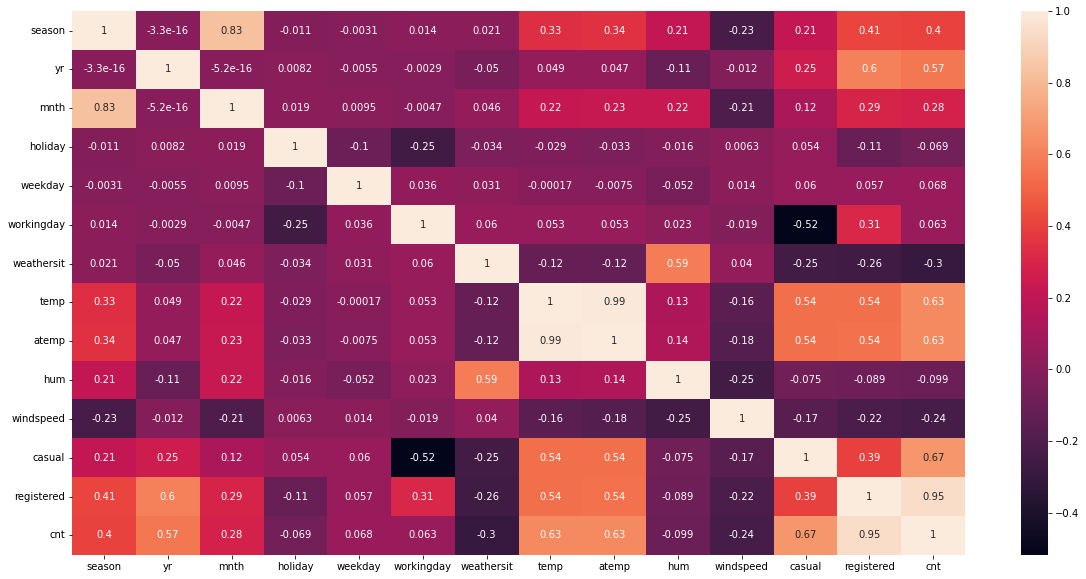

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data.corr(),annot=True)
plt.show()

In [15]:
# variable with highest correlation with target variable 

sorted(data.corr()['cnt'][:-3].items(),key = lambda x : x[1], reverse=True)[0]

('atemp', 0.6306853489531029)

* column 'atemp' have highest corrleation with the target variable 'cnt'

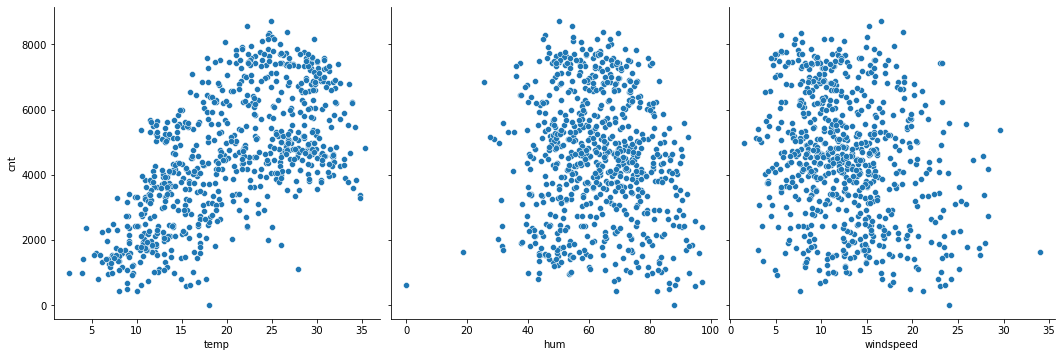

In [16]:
# comparison of continuous parameters with target variable
sns.pairplot(data=data,x_vars=['temp','hum','windspeed'],y_vars='cnt',height=5)
plt.show()

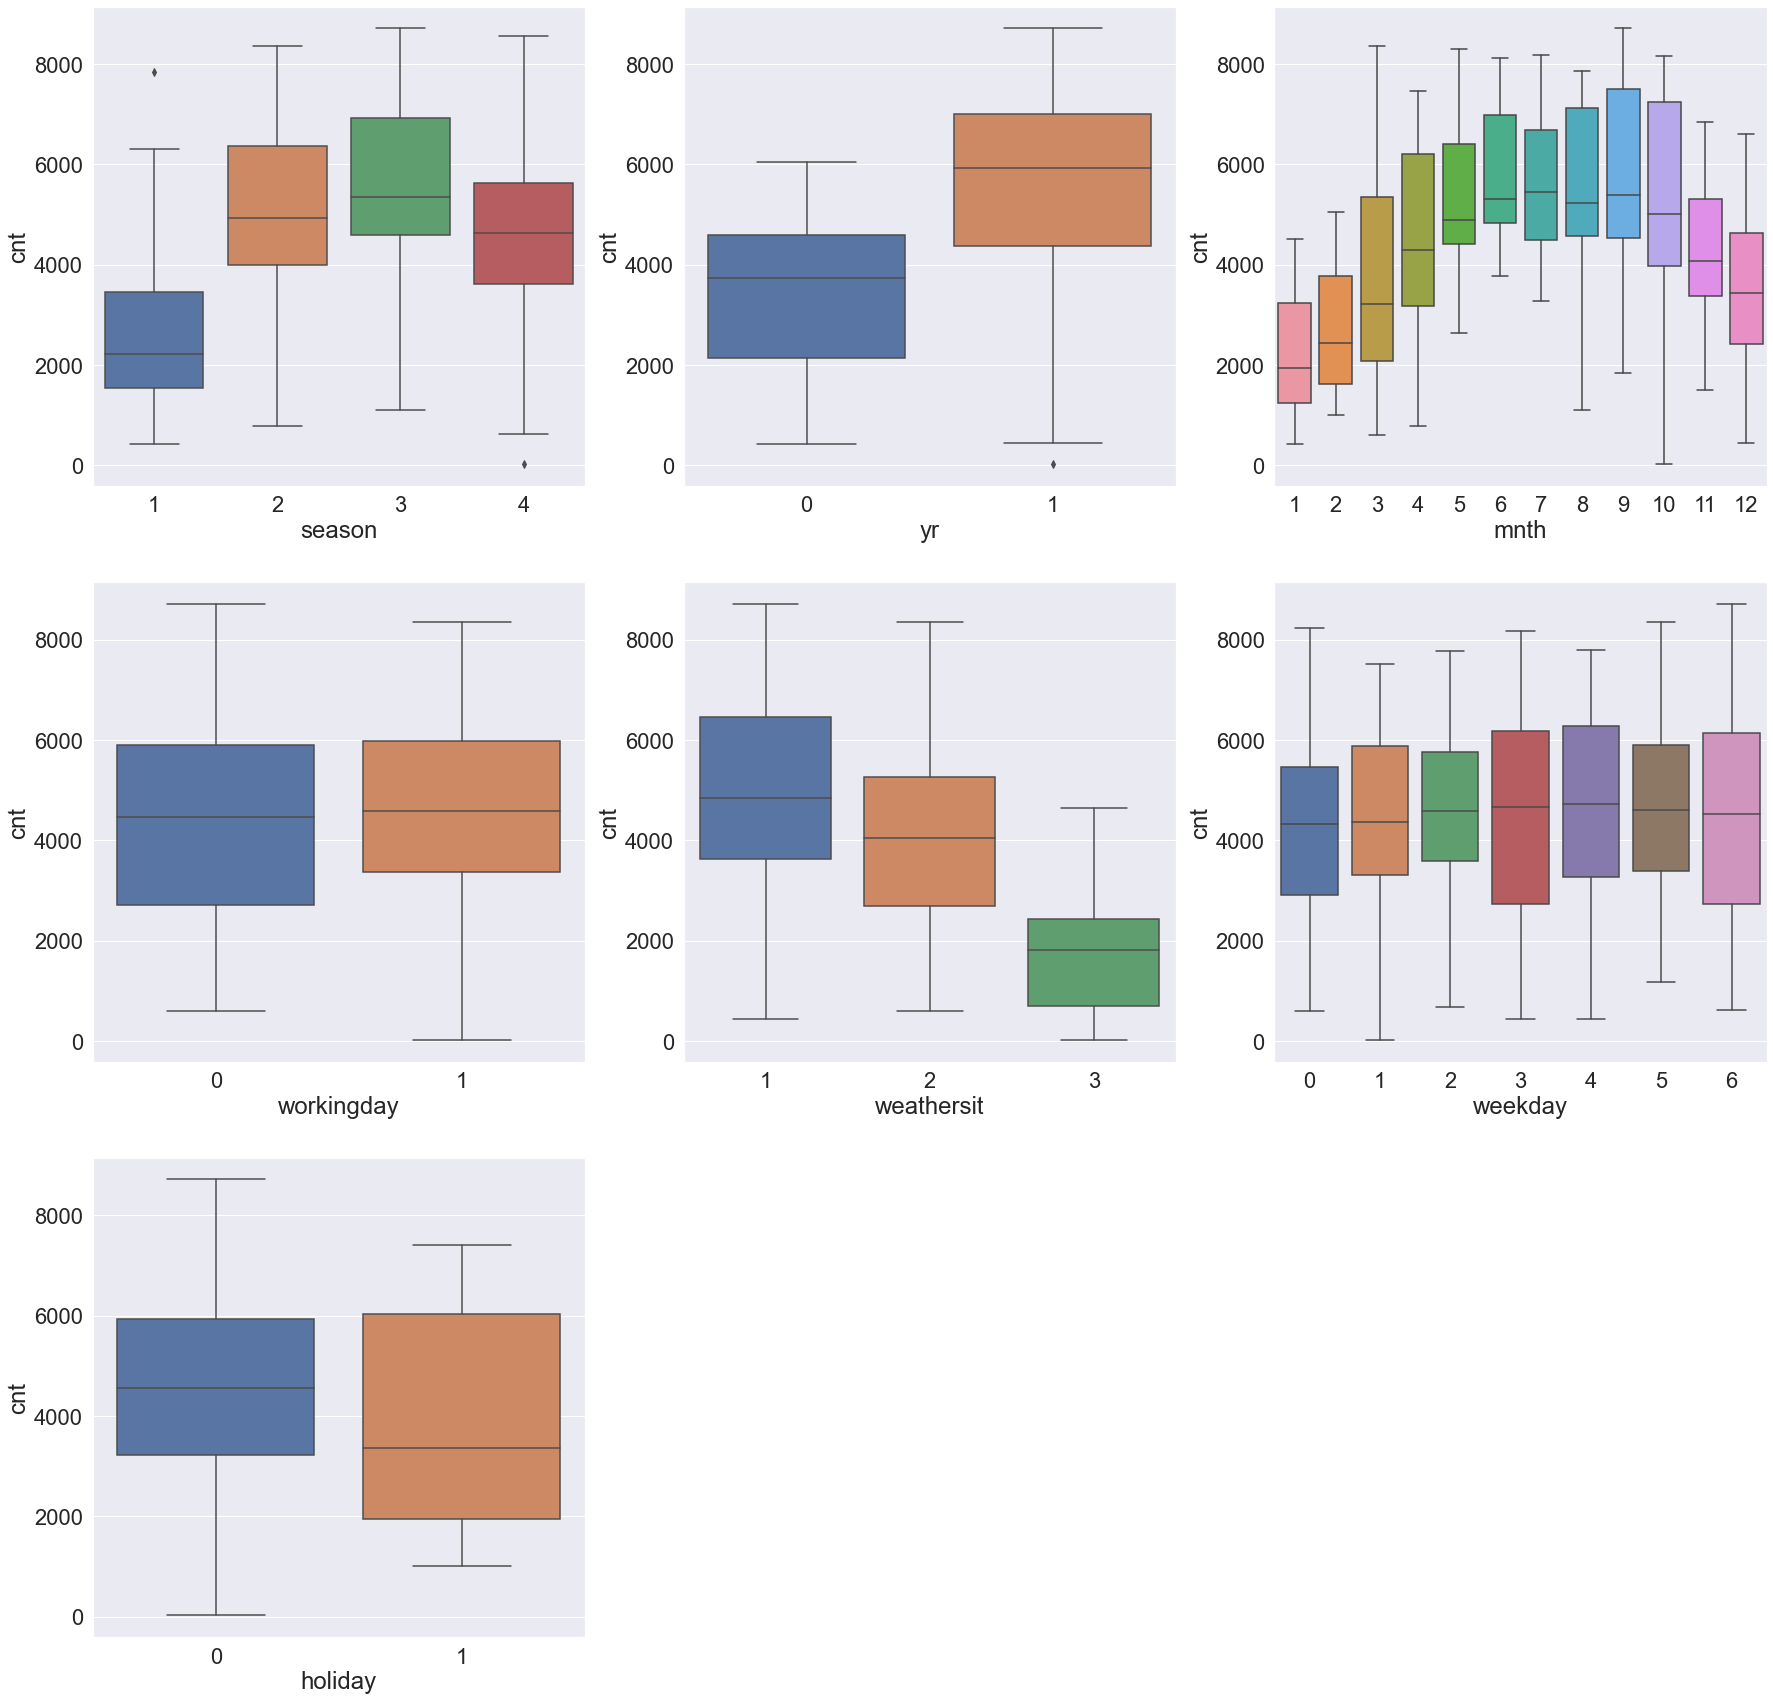

In [17]:
#Visualising discrete numerical or categorical Variables to understand data better
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = data)#yr','mnth','workingday','weathersit','weekday'
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = data)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = data)
plt.subplot(3,3,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = data)
plt.subplot(3,3,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = data)
plt.subplot(3,3,6)
sns.boxplot(x = 'weekday', y = 'cnt', data = data)
plt.subplot(3,3,7)
sns.boxplot(x = 'holiday', y = 'cnt', data = data)
plt.show()

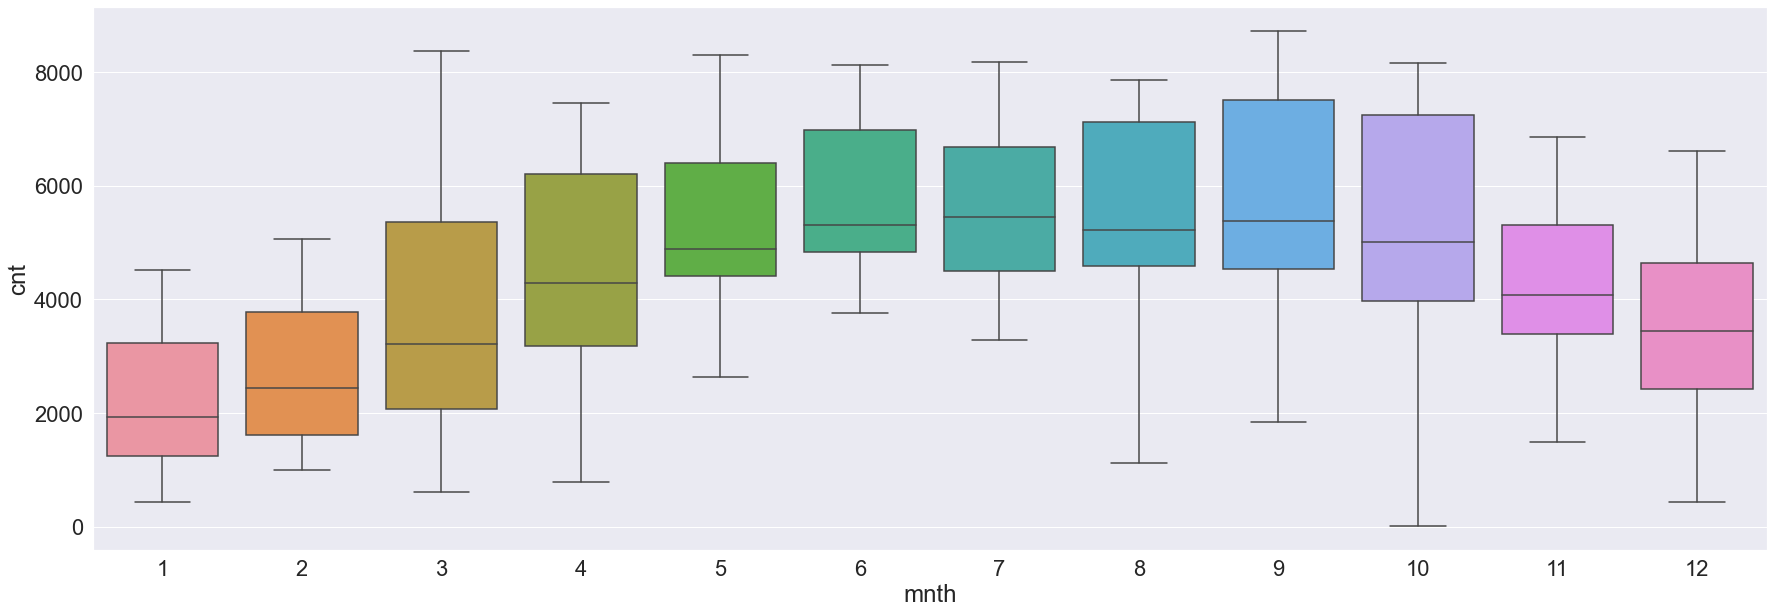

In [18]:
# month
plt.figure(figsize=(30, 10))
sns.boxplot(x = 'mnth', y = 'cnt', data = data)
plt.show()

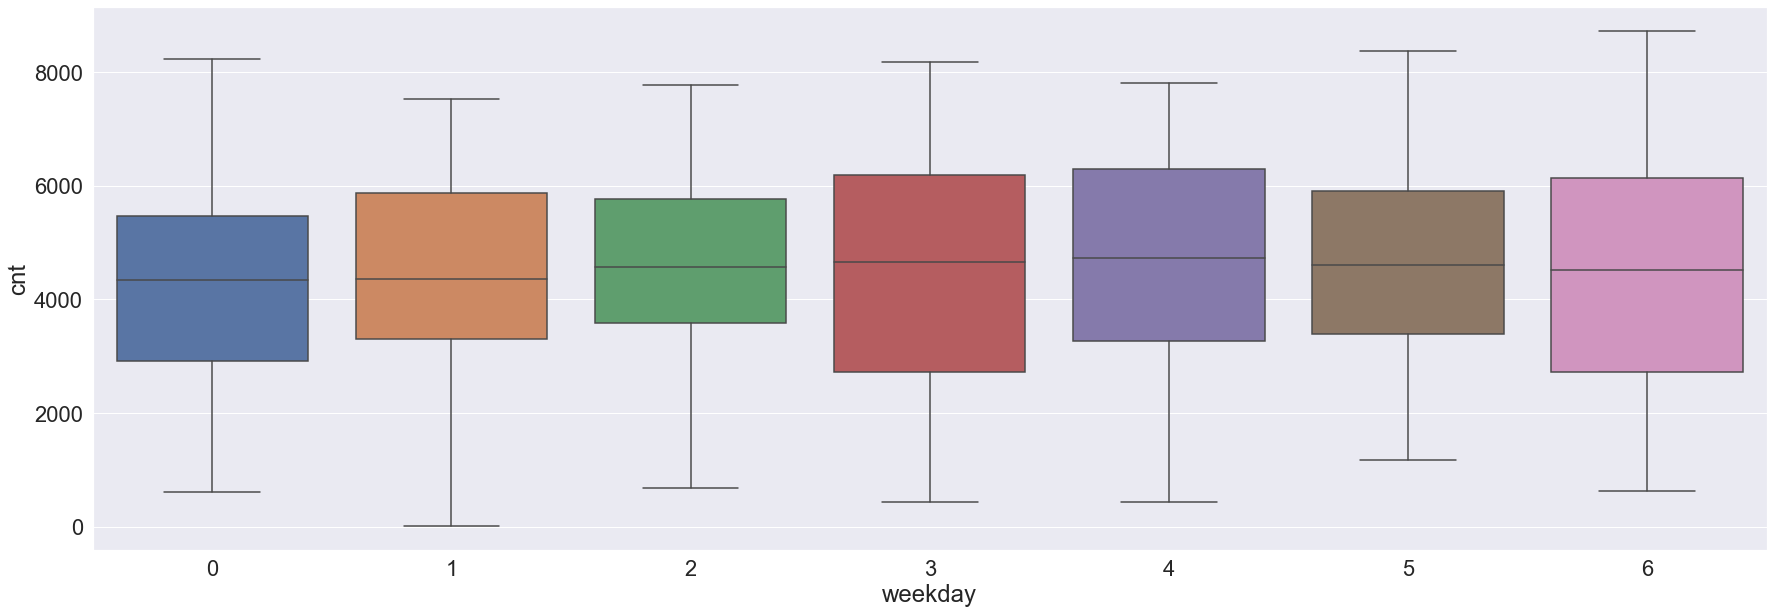

In [19]:
# weekday
plt.figure(figsize=(30, 10))
sns.boxplot(x = 'weekday', y = 'cnt', data = data)
plt.show()

# Data Exploration

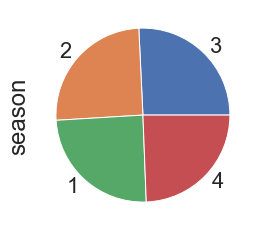

In [20]:
# season
data['season'].value_counts().plot.pie()
plt.show()

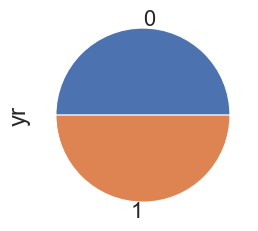

In [23]:
# yr
data['yr'].value_counts().plot.pie()
plt.show()

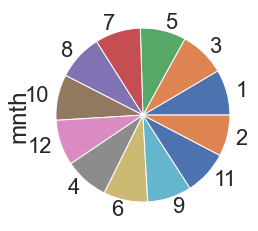

In [24]:
# month
data['mnth'].value_counts().plot.pie()
plt.show()

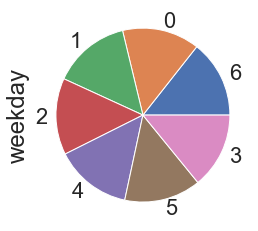

In [25]:
# weekday
data['weekday'].value_counts().plot.pie()
plt.show()

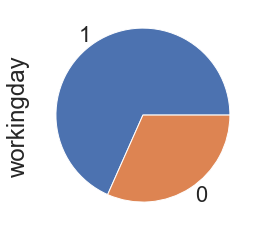

In [26]:
# working day
data['workingday'].value_counts().plot.pie()
plt.show()

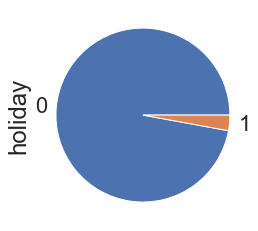

In [27]:
# holiday
data['holiday'].value_counts().plot.pie()
plt.show()

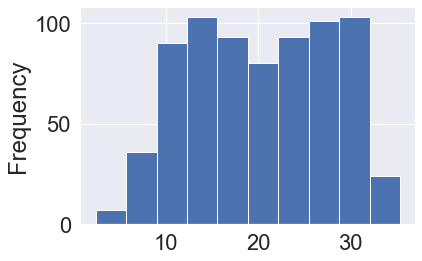

In [28]:
# temp
data['temp'].plot.hist()
plt.show()

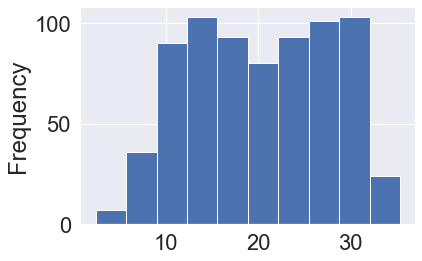

In [29]:
# temp
data['temp'].plot.hist()
plt.show()

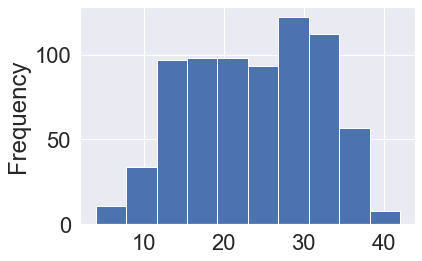

In [30]:
# atemp
data['atemp'].plot.hist()
plt.show()

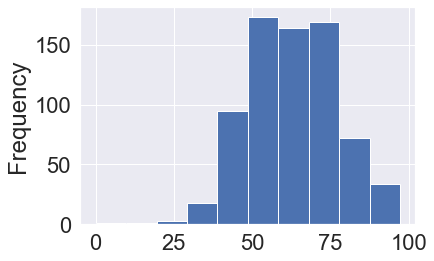

In [31]:
# hum
data['hum'].plot.hist()
plt.show()

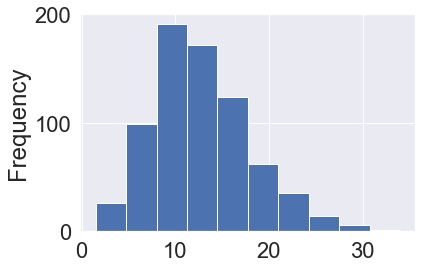

In [32]:
# windspeed
data['windspeed'].plot.hist()
plt.show()

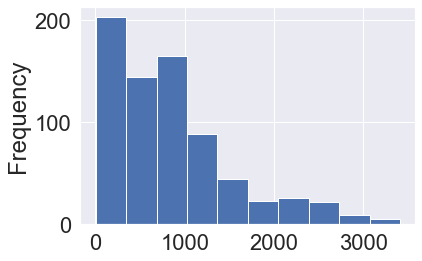

In [33]:
# casual users
data['casual'].plot.hist()
plt.show()

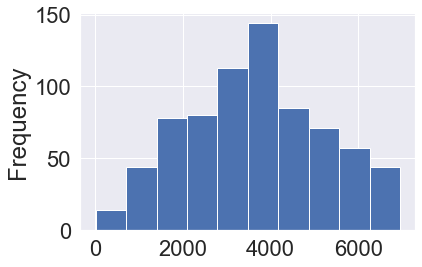

In [34]:
# registered users
data['registered'].plot.hist()
plt.show()

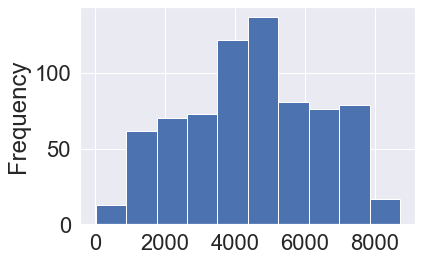

In [35]:
# cnt
data['cnt'].plot.hist()
plt.show()

#  Data Preparations

## add dummy columns

> season

* 1:spring, 
* 2:summer, 
* 3:fall, 
* 4:winter

In [36]:
# values
data['season'].value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [37]:
# change integers into season information
season={1:'spring', 2:'summer', 3:'fall', 4:'winter'}
data['season']=data['season'].map(season)

In [38]:
# new values
data['season'].value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [39]:
pd.concat([data[data['season']=='fall'][0:1],data[data['season']=='summer'][0:1],data[data['season']=='spring'][0:1],data[data['season']=='winter'][0:1]])

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
171,21-06-2018,fall,0,6,0,2,1,2,27.914153,31.88230,77.0417,11.458675,774,4061,4835
79,21-03-2018,summer,0,3,0,1,1,2,17.647835,20.48675,73.7391,19.348461,401,1676,2077
0,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
265,23-09-2018,winter,0,9,0,5,1,2,24.975847,26.10625,97.2500,5.250569,258,2137,2395


In [40]:
dummycolums=pd.get_dummies(data['season'])
pd.concat([dummycolums[dummycolums['fall']==1][0:1],dummycolums[dummycolums['spring']==1][0:1],dummycolums[dummycolums['summer']==1][0:1],dummycolums[dummycolums['winter']==1][0:1]])

,fall,spring,summer,winter
171,1,0,0,0
0,0,1,0,0
79,0,0,1,0
265,0,0,0,1


In [41]:
# create dummy variables for season information, drop (fall) sub-column
season_df=pd.get_dummies(data['season'],drop_first=True)
season_df.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [42]:
pd.concat([season_df[season_df['spring']==1][0:1],season_df[season_df['summer']==1][0:1],season_df[season_df['winter']==1][0:1]])

,spring,summer,winter
0,1,0,0
79,0,1,0
265,0,0,1


In [43]:
season_df[(season_df['spring']==0) & (season_df['summer']==0) & (season_df['winter']==0)][0:1]

,spring,summer,winter
171,0,0,0


* spring: 100
* summer: 010
* winter: 001
* fall: 000

In [44]:
# season information
season_info={'spring': '100','summer': '010','winter': '001','fall':'000'}

In [45]:
# add {season_df} column in {data} dataframe, and drop existng {(season)} column from {data} dataframe
data=pd.concat([data,season_df],axis=1).drop('season',axis=1)
data.head()

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter
0,01-01-2018,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0
1,02-01-2018,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0
2,03-01-2018,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0
3,04-01-2018,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0
4,05-01-2018,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0


> year

* 0: 2018, 
* 1: 2019

In [46]:
# values
data['yr'].value_counts()

0    365
1    365
Name: yr, dtype: int64

In [47]:
# change name of {yr} column to {yr_19}
data.rename(columns={'yr':'yr_19'},inplace=True)

In [48]:
# year information
year_info={'2018':'0','2019':'1'}

In [49]:
data.head()

,dteday,yr_19,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter
0,01-01-2018,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0
1,02-01-2018,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0
2,03-01-2018,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0
3,04-01-2018,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0
4,05-01-2018,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0


> weather situation
* 1: clear, 
* 2: mist, 
* 3: light_fall, 
* 4: heavy_fall

In [50]:
# values
data['weathersit'].value_counts()

1    463
2    246
3    21 
Name: weathersit, dtype: int64

In [51]:
# change integers into weather information
weather={1:'clear', 2:'mist', 3:'light_fall', 4:'heavy_fall'}
data['weathersit']=data['weathersit'].map(weather)

In [52]:
# new values
data['weathersit'].value_counts()

clear         463
mist          246
light_fall    21 
Name: weathersit, dtype: int64

heavy_fall value not in {weathersit} column

In [53]:
# create dummy variables for weather information, drop (clear) sub-column
weathersit_df=pd.get_dummies(data['weathersit'],drop_first=True)
weathersit_df.head()

,light_fall,mist
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0


In [54]:
# weather situation information
weather_info={'light fall': '10','mist': '01','clear': '00'}

In [69]:
# add {weathersit_df} column in {data} dataframe, and drop existng {(weathersit)} column from {data} dataframe
data=pd.concat([data,weathersit_df],axis=1).drop('weathersit',axis=1)
data.head()

KeyError: "['weathersit'] not found in axis"

> month
* 1:'1jan',
* 2:'2feb',
* 3:'3mar',
* 4:'4apr',
* 5:'6may',
* 6:'6jun',
* 7:'7jul',
* 8:'8aug',
* 9 :'9sep',
* 10:'10oct',
* 11:'11nov',
* 12:'12dec'

In [70]:
# values
data['mnth'].value_counts().index

KeyError: 'mnth'

In [ ]:
# cretae month dictioary
month=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
months={x+1:('0'+str(x+1)+"_"+y if x<9 else str(x+1)+"_"+y) for x,y in enumerate(month)}
print(months)

In [ ]:
# rename values
data['mnth']=data['mnth'].map(months)

In [ ]:
# new values
data['mnth'].value_counts().index

In [ ]:
# create dummy variables for month, drop (01_jan) sub-column
month_df=pd.get_dummies(data['mnth'],drop_first=True)
month_df.head()

In [71]:
# month information
def func(x):
    return "".join(list(map(str,month_df.iloc[[x+x*31]].values.tolist()[0])))
month_info={
    y:func(x) for x,y in enumerate(month)
}

In [72]:
# add {month_df} column in {data} dataframe, and drop existng {(mnth)} column from {data} dataframe
data=pd.concat([data,month_df],axis=1).drop('mnth',axis=1)
data.head()

KeyError: "['mnth'] not found in axis"

> weekday
* 0: 'Sun', 
* 1: 'Mon', 
* 2: 'Tue', 
* 3: 'Wed', 
* 4: 'Thur', 
* 5: 'Fri', 
* 6: 'Sat'

In [73]:
# values
data['weekday'].value_counts().index

KeyError: 'weekday'

In [74]:
# changing values in {weekend} column 

weekday= ['Sun','Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat']
weekdays={x:str(x)+'_'+y for x,y in enumerate(weekday)}

data['weekday']=data['weekday'].map(weekdays)

KeyError: 'weekday'

In [ ]:
# new values
data['weekday'].value_counts().index

In [ ]:
# create dummy variables for weekday, drop (0_Sun) sub-column
weekday_df=pd.get_dummies(data['weekday'],drop_first=True)
weekday_df.head()

In [ ]:
# weekday information
def func(x):
    return "".join(list(map(str,weekday_df.iloc[[x+1]].values.tolist()[0])))
weekday_info={
    y:func(x) for x,y in enumerate(weekday)
}

In [75]:
# add {weekday_df} column in {data} dataframe, and drop existng {(weekday)} column from {data} dataframe
data=pd.concat([data,weekday_df],axis=1).drop('weekday',axis=1)
data.head()

KeyError: "['weekday'] not found in axis"

## derive columns

> feeling temperature difference
* temp - atemp

In [76]:
# add {feeling_temp_diff} column
data['temp_dif_f']=data['atemp']-data['temp']
data.head()

,dteday,yr_19,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter,light_fall,mist,02_feb,03_mar,04_apr,05_may,06_jun,07_jul,08_aug,09_sep,10_oct,11_nov,12_dec,1_Mon,2_Tue,3_Wed,4_Thur,5_Fri,6_Sat,temp_dif_f
0,01-01-2018,0,0,0,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.070403
1,02-01-2018,0,0,0,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.784352
2,03-01-2018,0,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.419326
3,04-01-2018,0,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.406100
4,05-01-2018,0,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.158263


In [77]:
# check collinearuty between {atemp} and {temp} column

data['temp'].corr(data['atemp'])

0.9916961786905648

In [78]:
# {atemp} and {temp} columns are highly collinear, thus dropping {atemp} column

data=data.drop(columns='atemp')
data.head()

,dteday,yr_19,holiday,workingday,temp,hum,windspeed,casual,registered,cnt,spring,summer,winter,light_fall,mist,02_feb,03_mar,04_apr,05_may,06_jun,07_jul,08_aug,09_sep,10_oct,11_nov,12_dec,1_Mon,2_Tue,3_Wed,4_Thur,5_Fri,6_Sat,temp_dif_f
0,01-01-2018,0,0,0,14.110847,80.5833,10.749882,331,654,985,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.070403
1,02-01-2018,0,0,0,14.902598,69.6087,16.652113,131,670,801,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.784352
2,03-01-2018,0,0,1,8.050924,43.7273,16.636703,120,1229,1349,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.419326
3,04-01-2018,0,0,1,8.200000,59.0435,10.739832,108,1454,1562,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2.406100
4,05-01-2018,0,0,1,9.305237,43.6957,12.522300,82,1518,1600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.158263


In [79]:
# data['atemp'] = data['temp'] + data['temp_dif_f']

# rearrange columns

In [80]:
data=data[['yr_19','holiday', 'workingday','spring', 'summer', 'winter', 'light_fall', 'mist', '02_feb', '03_mar', '04_apr', '05_may', '06_jun', '07_jul', '08_aug', '09_sep', '10_oct', '11_nov', '12_dec', '1_Mon', '2_Tue', '3_Wed', '4_Thur', '5_Fri', '6_Sat','temp','temp_dif_f','hum', 'windspeed','casual', 'registered','cnt']]
data.head()

,yr_19,holiday,workingday,spring,summer,winter,light_fall,mist,02_feb,03_mar,04_apr,05_may,06_jun,07_jul,08_aug,09_sep,10_oct,11_nov,12_dec,1_Mon,2_Tue,3_Wed,4_Thur,5_Fri,6_Sat,temp,temp_dif_f,hum,windspeed,casual,registered,cnt
0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14.110847,4.070403,80.5833,10.749882,331,654,985
1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.902598,2.784352,69.6087,16.652113,131,670,801
2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,8.050924,1.419326,43.7273,16.636703,120,1229,1349
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8.200000,2.406100,59.0435,10.739832,108,1454,1562
4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,9.305237,2.158263,43.6957,12.522300,82,1518,1600


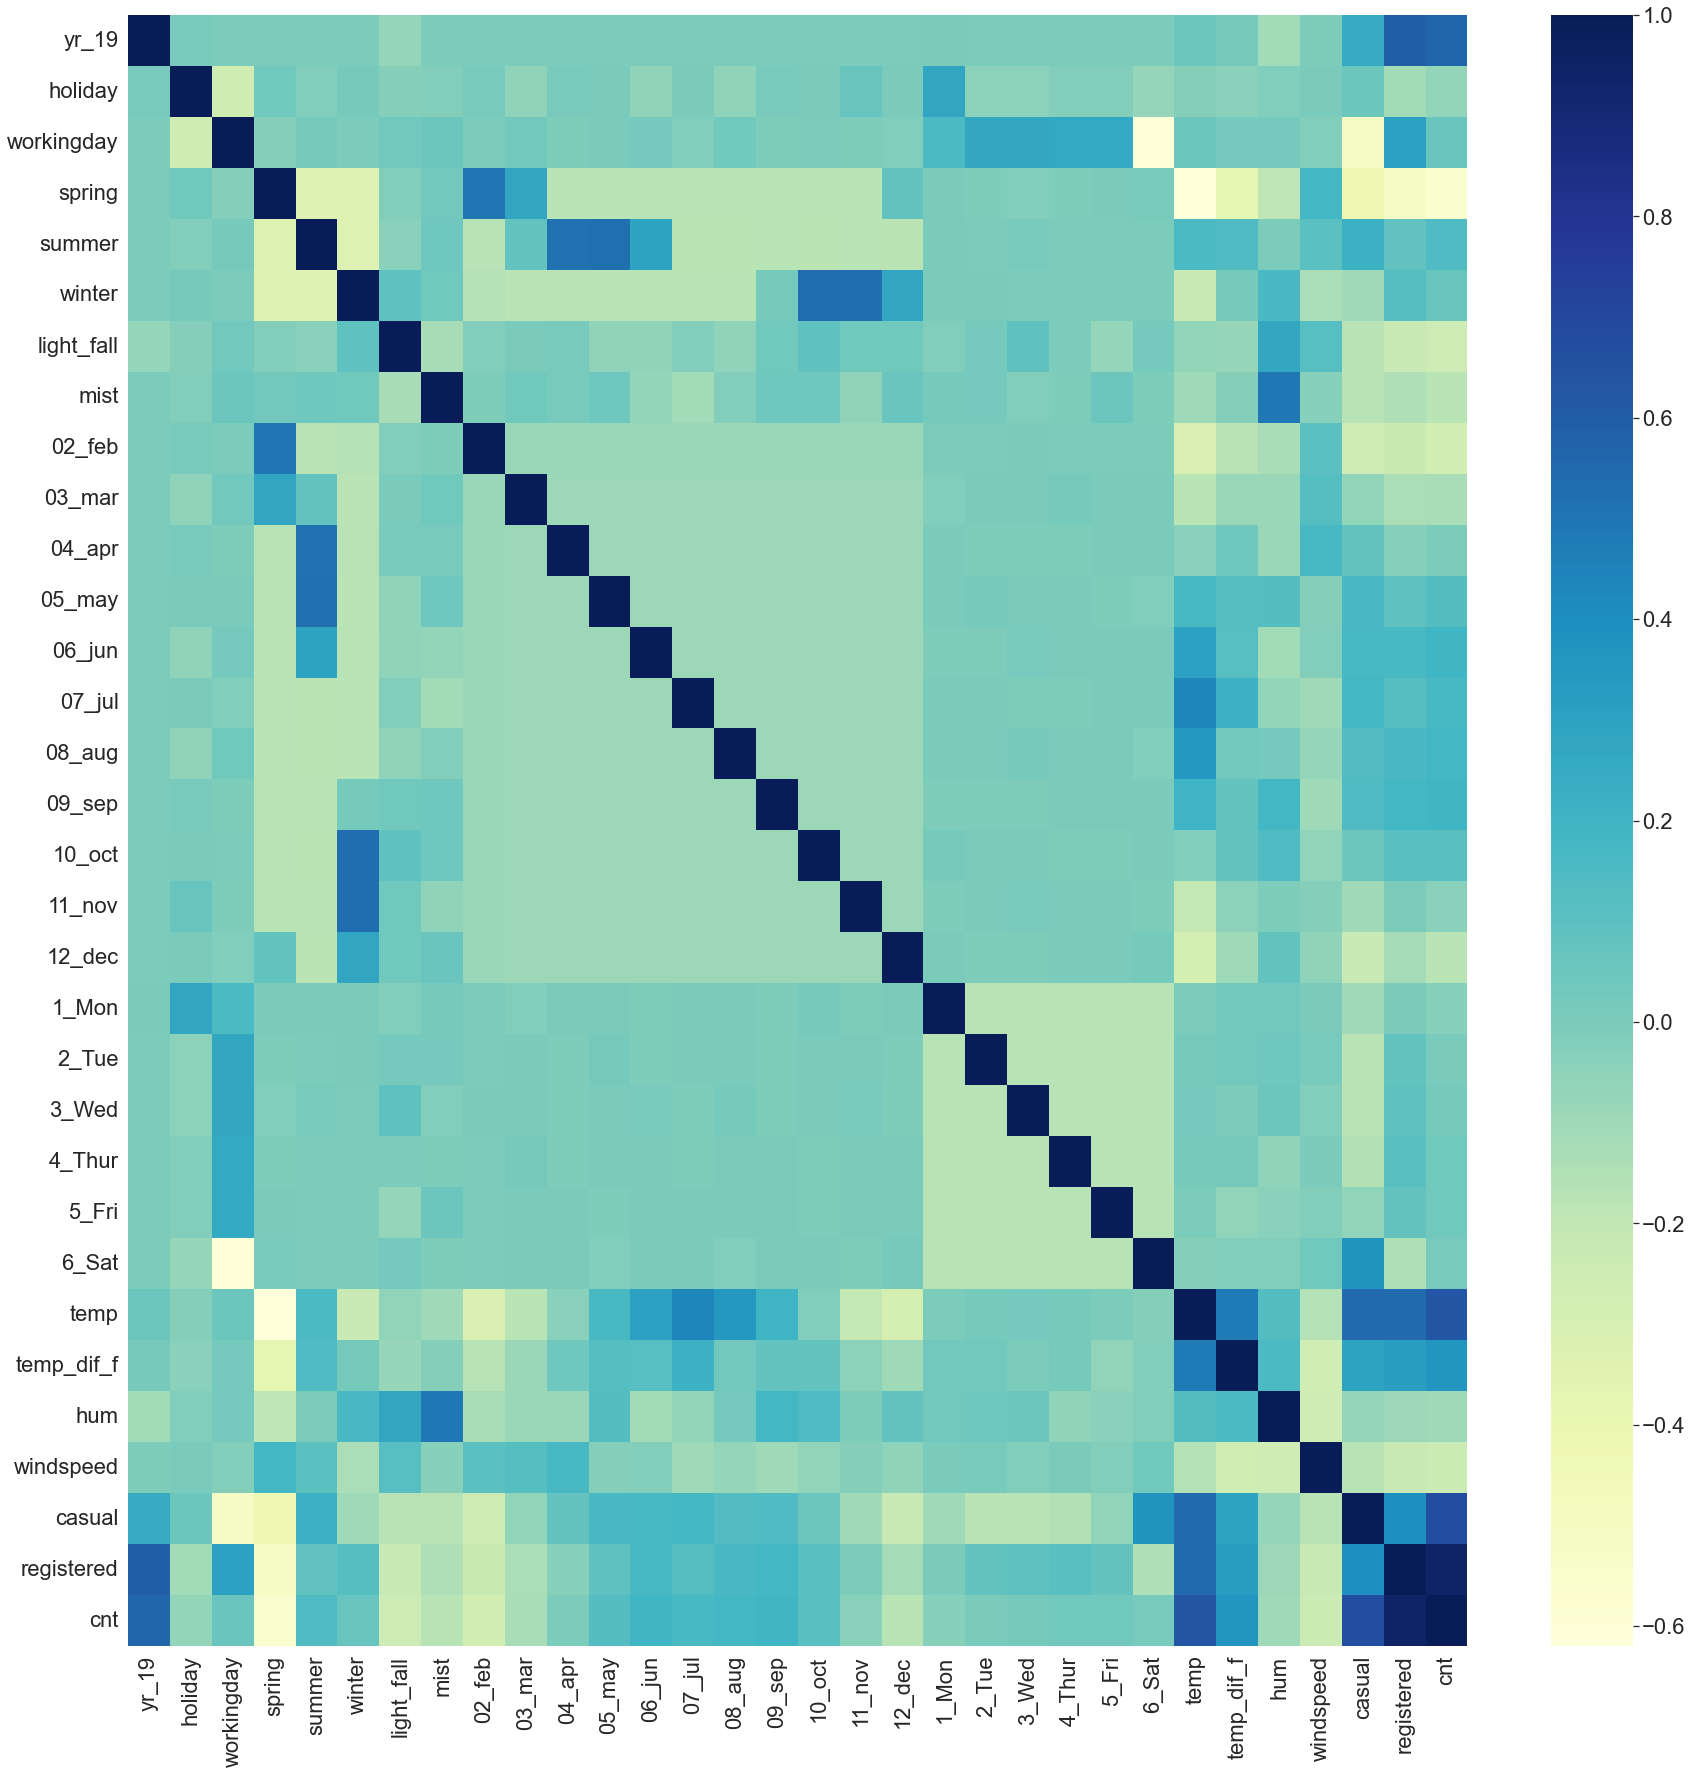

In [81]:
# checking correlation
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(data.corr(),cmap="YlGnBu")
plt.show()

# Model Building

In [98]:
# deep copy of original data
# dropping {casual}{registered} columns from dataset as {cnt} column is target variable

data_temp=data.copy(deep=True).drop(columns=['casual','registered'])
data_temp.head()

,yr_19,holiday,workingday,spring,summer,winter,light_fall,mist,02_feb,03_mar,04_apr,05_may,06_jun,07_jul,08_aug,09_sep,10_oct,11_nov,12_dec,1_Mon,2_Tue,3_Wed,4_Thur,5_Fri,6_Sat,temp,temp_dif_f,hum,windspeed,cnt
0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14.110847,4.070403,80.5833,10.749882,985
1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14.902598,2.784352,69.6087,16.652113,801
2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,8.050924,1.419326,43.7273,16.636703,1349
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,8.200000,2.406100,59.0435,10.739832,1562
4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,9.305237,2.158263,43.6957,12.522300,1600


In [99]:
# split dataset into train, validation, and test dataset
# training dataset -- data_rfe_train
# validation dataset -- data_rfe_val
# testing dataset -- data_rfe_test

np.random.seed(0)
# split into training and evaluation dataset, 70&-30%
data_train,data_eval=train_test_split(data_temp,train_size=0.7,random_state=100)
# split into validation and test data, 50%-50%
data_val,data_test=train_test_split(data_eval,test_size=0.5,random_state=100)

In [100]:
# check shapes
data_train.shape,data_val.shape,data_test.shape

((510, 30), (110, 30), (110, 30))

In [101]:
# scaling features, using min-max normalized scaling

scaler=MinMaxScaler()

In [102]:
#  numerical consitnuous variables
continuous_parameters=['temp', 'temp_dif_f','hum', 'windspeed', 'cnt']

In [103]:
# fit and transform numerical values in training dataseta

# fit and transform all numerical values
data_train[continuous_parameters]=scaler.fit_transform(data_train[continuous_parameters])

data_train.head()

,yr_19,holiday,workingday,spring,summer,winter,light_fall,mist,02_feb,03_mar,04_apr,05_may,06_jun,07_jul,08_aug,09_sep,10_oct,11_nov,12_dec,1_Mon,2_Tue,3_Wed,4_Thur,5_Fri,6_Sat,temp,temp_dif_f,hum,windspeed,cnt
576,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.815169,0.864313,0.725633,0.264686,0.827658
426,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.442393,0.856072,0.640189,0.255342,0.465255
728,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.245101,0.751317,0.498067,0.663106,0.204096
482,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.395666,0.845511,0.504508,0.188475,0.482973
111,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.345824,0.799644,0.751824,0.380981,0.191095


In [104]:
data_train.describe()

,yr_19,holiday,workingday,spring,summer,winter,light_fall,mist,02_feb,03_mar,04_apr,05_may,06_jun,07_jul,08_aug,09_sep,10_oct,11_nov,12_dec,1_Mon,2_Tue,3_Wed,4_Thur,5_Fri,6_Sat,temp,temp_dif_f,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.243137,0.247059,0.247059,0.029412,0.345098,0.066667,0.098039,0.078431,0.084314,0.076471,0.076471,0.096078,0.080392,0.084314,0.086275,0.084314,0.150980,0.131373,0.158824,0.133333,0.127451,0.154902,0.537440,0.843905,0.650480,0.320883,0.513499
std,0.500429,0.157763,0.468282,0.429398,0.431725,0.431725,0.169124,0.475867,0.249689,0.297660,0.269113,0.278131,0.266010,0.266010,0.294988,0.272166,0.278131,0.281045,0.278131,0.358381,0.338139,0.365870,0.340268,0.333805,0.362166,0.225858,0.052463,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.339853,0.828587,0.538643,0.199179,0.356420
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.542596,0.855987,0.653714,0.296763,0.518638
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.735215,0.866484,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [107]:
# using {cnt} as -- target variables
# using all other variables except -- feature variables

y_train=data_train['cnt'].to_numpy()
X_train=data_train.drop('cnt',axis=1)

In [110]:
# target values in training dataset

y_train[:5]

array([0.82765762, 0.46525541, 0.20409572, 0.48297285, 0.19109526])

In [111]:
X_train.head()

,yr_19,holiday,workingday,spring,summer,winter,light_fall,mist,02_feb,03_mar,04_apr,05_may,06_jun,07_jul,08_aug,09_sep,10_oct,11_nov,12_dec,1_Mon,2_Tue,3_Wed,4_Thur,5_Fri,6_Sat,temp,temp_dif_f,hum,windspeed
576,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0.815169,0.864313,0.725633,0.264686
426,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.442393,0.856072,0.640189,0.255342
728,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.245101,0.751317,0.498067,0.663106
482,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.395666,0.845511,0.504508,0.188475
111,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.345824,0.799644,0.751824,0.380981


#### check assumptions of linear regression

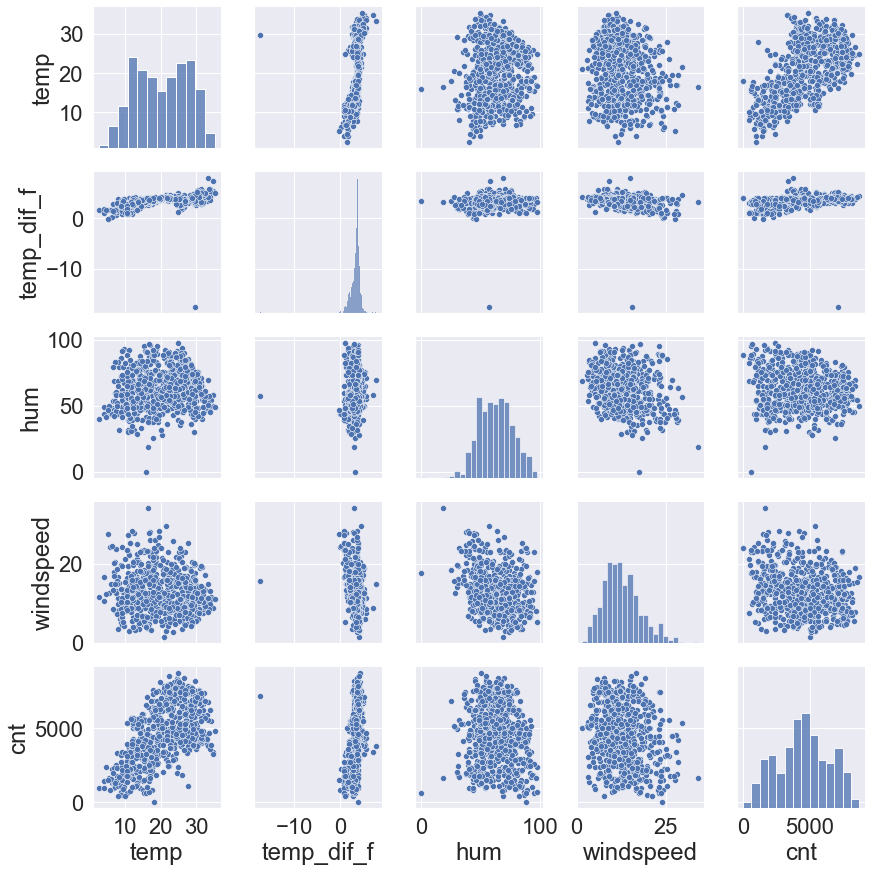

In [112]:
# checking linear relationship
sns.pairplot(data[continuous_parameters])
plt.show()

* linear or similar relation betweem 'cnt' column and 'tmp' variable.
* no relation can be observed between other variables.
* no sign of collinearity in feature variables

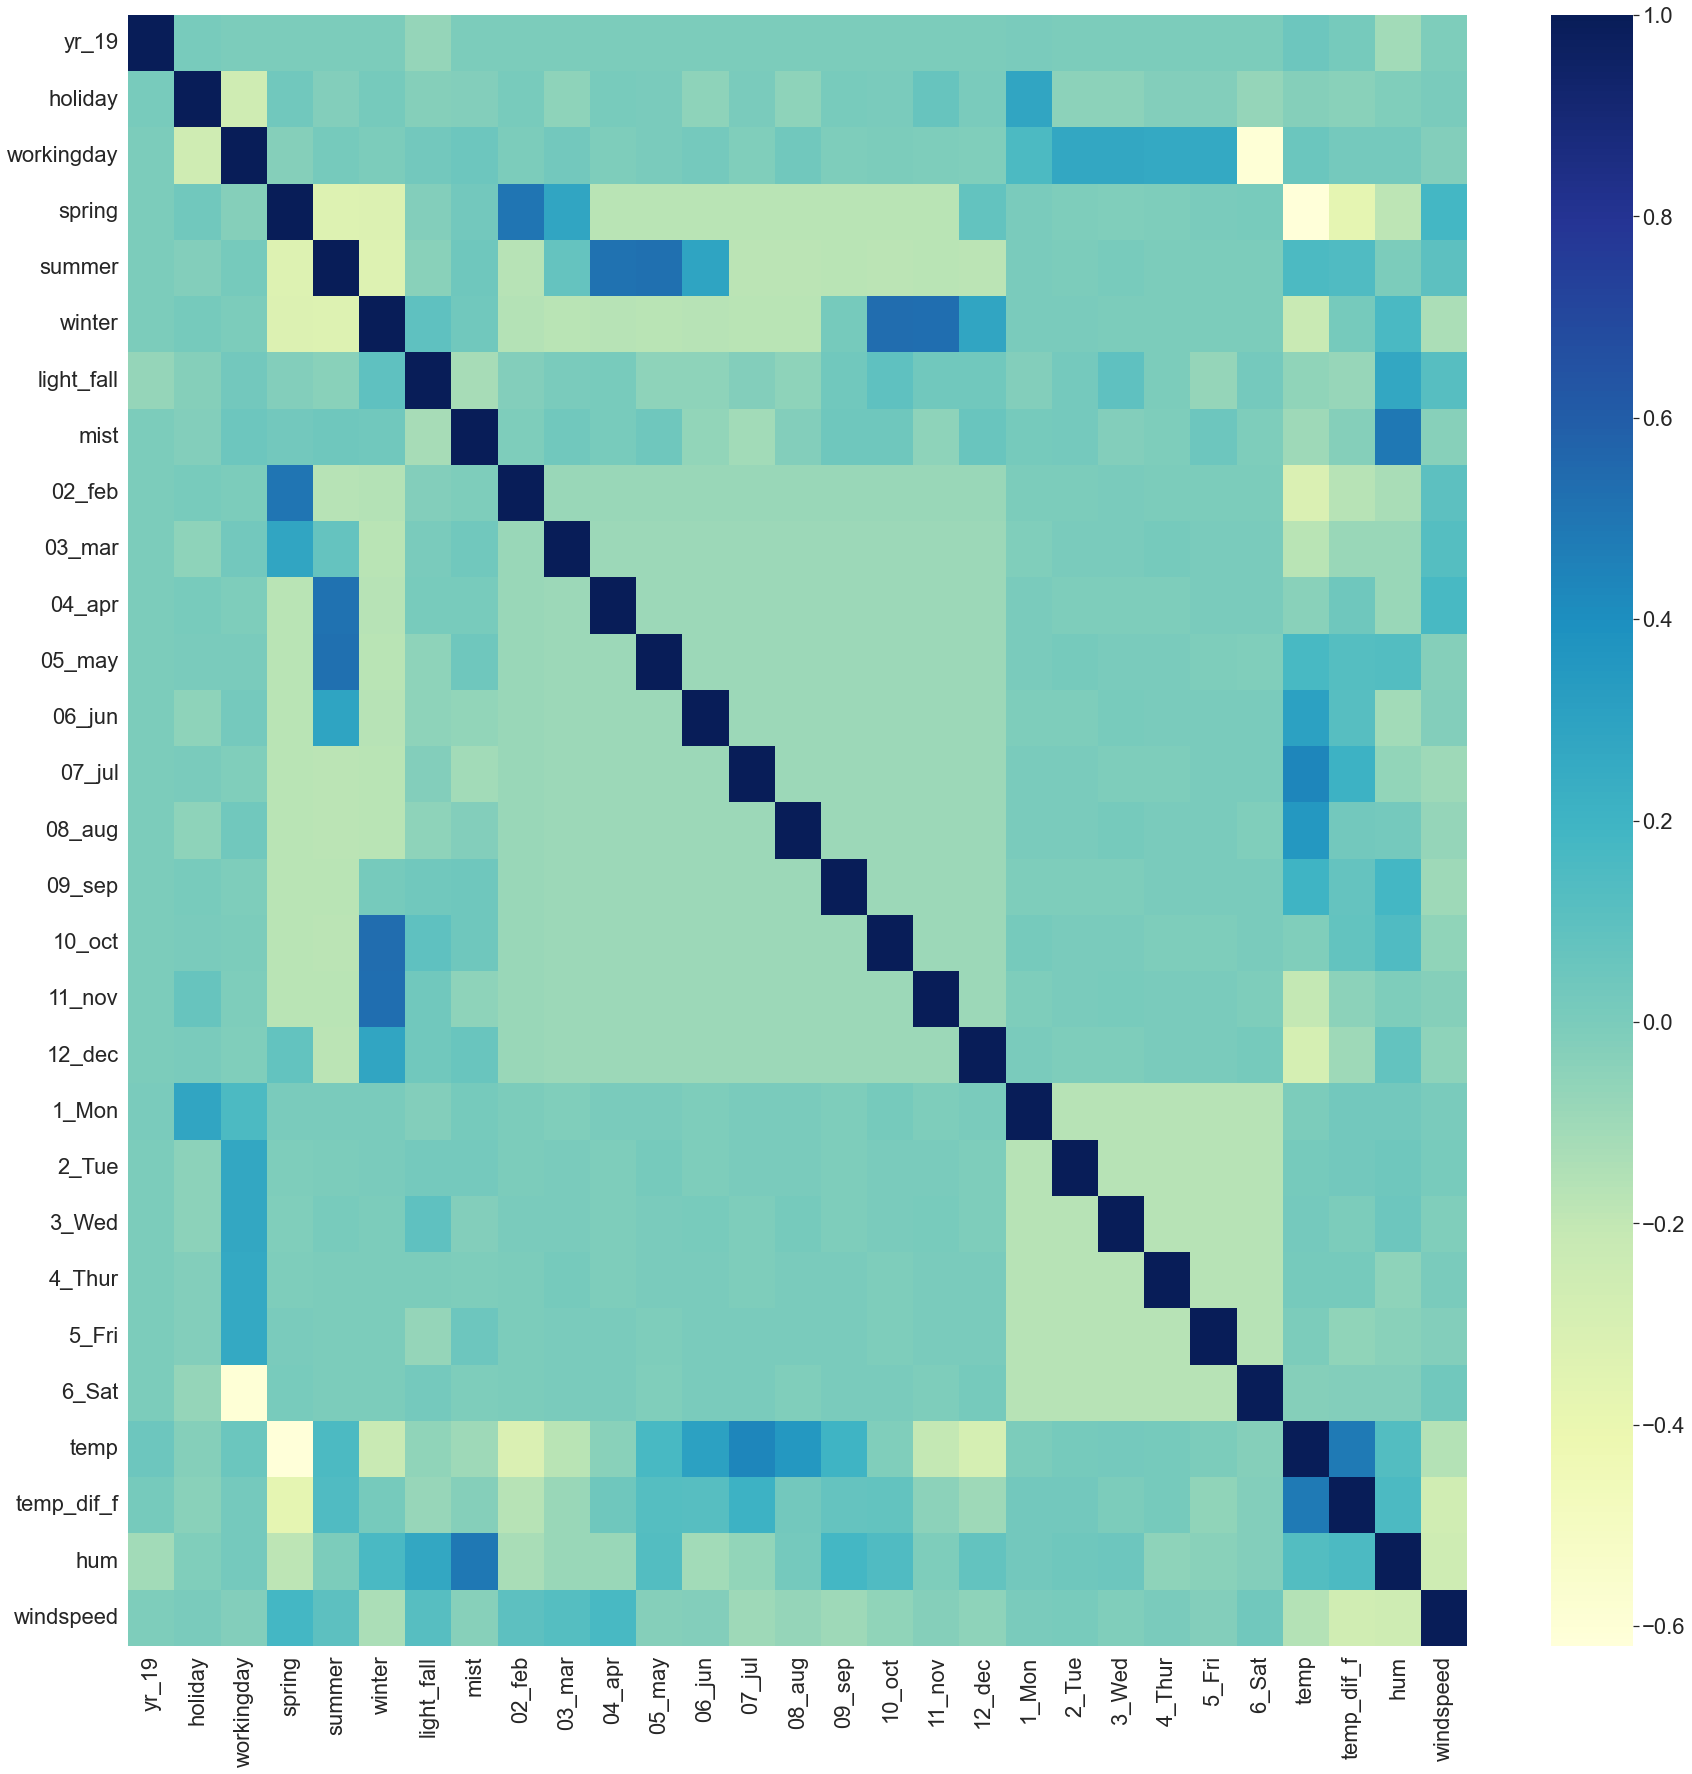

In [181]:
# checking correlation
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(data.iloc[:,:-3].corr(),cmap="YlGnBu")
plt.show()

* some correlation between feature variables is observed.

### linear regresison model

In [182]:
# build linear regerssion models

linear_regression_model=LinearRegression()

# fit model with training dataset
linear_regression_model.fit(X_train,y_train)

# preidct values on training dataset
y_train_predict=linear_regression_model.predict(X_train)

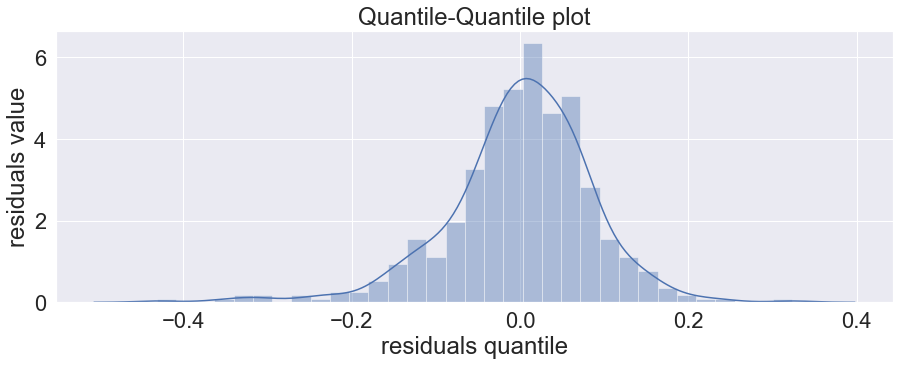

In [218]:
# checking assumption on error terms(residuals)

# residual
training_residuals = y_train - y_train_predict

# Q-Q plot
plt.figure(figsize=(15,5))
fig_qqplot = sns.distplot(training_residuals)
fig_qqplot.set(xlabel='residuals quantile', ylabel='residuals value',title='Quantile-Quantile plot')

plt.show()

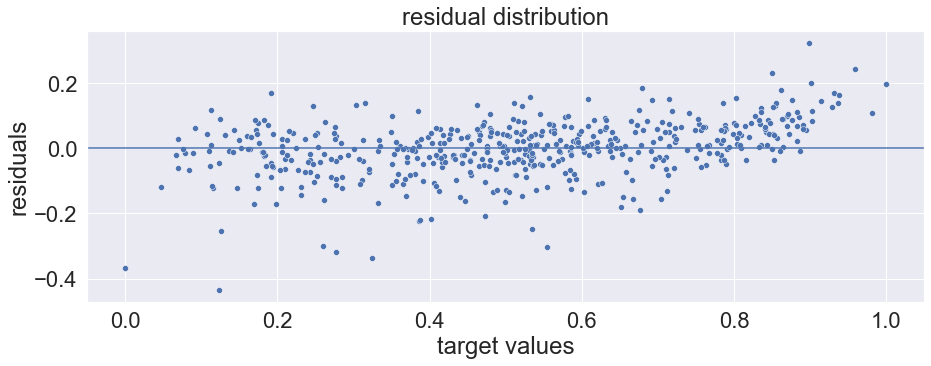

In [214]:
# residual distribution
plt.figure(figsize=(15,5))

fig_dist = sns.scatterplot(x=y_train,y=residual)
fig_dist.set(xlabel='target values', ylabel='residuals',title='residual distribution')

plt.axhline(0)
plt.show()

* error terms are normally distributed.
* mean of error terms is 0.
* no pattern observed in residual distribution.
* error terms are homoscedasticity in nature, constant variance in points.

### finding best features with recursive feature eliminiation method using sklearn

In [219]:
# select 2/3 best features from dataset using linear regression model -- 20

rfe=RFE(linear_regression_model,n_features_to_select=20).fit(X_train,y_train)

In [220]:
# total columns
len(X_train.columns)

29

In [221]:
# important features from linear regression model

useful_features = X_train.columns[rfe.support_]
print (list(useful_features))

# non-important features from linear regression models

non_useful_features = X_train.columns[~rfe.support_]

['yr_19', 'holiday', 'workingday', 'spring', 'summer', 'winter', 'light_fall', 'mist', '02_feb', '03_mar', '04_apr', '05_may', '06_jun', '08_aug', '09_sep', '10_oct', '6_Sat', 'temp', 'hum', 'windspeed']


In [224]:
# rank of useful features with linear regression model

print(sorted(list(zip(useful_features,rfe.ranking_)), key=lambda x: x[1]))

[('yr_19', 1), ('holiday', 1), ('workingday', 1), ('spring', 1), ('summer', 1), ('winter', 1), ('light_fall', 1), ('mist', 1), ('02_feb', 1), ('03_mar', 1), ('04_apr', 1), ('05_may', 1), ('06_jun', 1), ('09_sep', 1), ('10_oct', 1), ('6_Sat', 1), ('08_aug', 3), ('temp', 4), ('hum', 5), ('windspeed', 6)]


### stats model

In [248]:
# use rfe supported columns

X_train_rfe=X_train.copy()

In [263]:
# stat model function

def stat_model_func(columns=useful_features):
    
    global X_train_rfe,y_train
    
    X_train_rfe_temp=X_train_rfe[columns]

    X_train_rfe_sm_temp=sm.add_constant(X_train_rfe_temp)

    stat_model_temp=sm.OLS(y_train,X_train_rfe_sm_temp).fit()

    return stat_model_temp

In [273]:
# variation inflation factor

def vif_func(columns=useful_features):
    
    global X_train_rfe
    
    vif_temp=pd.DataFrame()
    
    X_train_rfe_temp=X_train_rfe[columns]
    
    X_train_rfe_sm_temp=sm.add_constant(X_train_rfe_temp)

    vif_temp['Features']=X_train_rfe_sm_temp.columns
    
    vif_temp['VIF']=[round(variance_inflation_factor(X_train_rfe_sm_temp.values,i),2) for i in range(X_train_rfe_sm_temp.shape[1])]

    vif_temp = vif_temp.sort_values(by='VIF',ascending=False)
    
    return vif_temp

In [275]:
# residuals plot

def plot_residuals_func(columns=useful_features):
    
    global X_train_rfe
    
    X_train_rfe_temp=X_train_rfe[columns]

    X_train_rfe_sm_temp=sm.add_constant(X_train_rfe_temp)

    stat_model=sm.OLS(y_train,X_train_rfe_sm_temp).fit()

    y_train_pred=stat_model.predict(X_train_rfe_sm_temp)

    residual = y_train - y_train_pred

    plt.figure(figsize=(15,5))

    fig_temp =  sns.distplot(residual)
    
    plt.show()
    
    return fig_temp

### build first stat model with useful features

In [267]:
# create stats model

# columns array
useful_features

# create dataframe
X_train_rfe_01=X_train_rfe[useful_features]

# add constant
X_train_rfe_sm_01=sm.add_constant(X_train_rfe_01)

# create model and fit
stat_model_01=sm.OLS(y_train,X_train_rfe_sm_01).fit()

# summary
stat_model_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     140.2
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          7.28e-188
Time:                        22:10:32   Log-Likelihood:                 525.26
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     489   BIC:                            -919.6
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2385      0.037      6.419      0.000       0.166       0.312
yr_19          0.2313      0.008     28.958      0.000       0.216       0.247
holiday       -0.0491      0.027     -1.833      0.067      -0.102       0.004
workingday     0.0437      0.011      3.807      0.000       0.021       0.066
spring        -0.0565      0.024     -2.368      0.018      -0.103      -0.010
summer         0.0364      0.024      1.487      0.138      -0.012       0.084
winter         0.1092      0.020      5.473      0.000       0.070       0.148
light_fall    -0.2538      0.026     -9.720      0.000      -0.305      -0.203
mist          -0.0586      0.010     -5.680      0.000      -0.079      -0.038
02_feb         0.0238      0.019      1.256      0.210      -0.013       0.061
03_mar         0.0538      0.018      3.021      0.003       0.019       0.089
04_apr         0.0474      0.026      1.828      0.068      -0.004       0.098
05_may         0.0707      0.026      2.682      0.008       0.019       0.123
06_jun         0.0458      0.023      2.025      0.043       0.001       0.090
08_aug         0.0576      0.018      3.213      0.001       0.022       0.093
09_sep         0.1247      0.017      7.181      0.000       0.091       0.159
10_oct         0.0467      0.017      2.680      0.008       0.012       0.081
6_Sat          0.0540      0.014      3.732      0.000       0.026       0.082
temp           0.4619      0.037     12.569      0.000       0.390       0.534
hum           -0.1567      0.038     -4.151      0.000      -0.231      -0.083
windspeed     -0.1855      0.025     -7.280      0.000      -0.236      -0.135
==============================================================================
Omnibus:                       80.793   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.887
Skew:                          -0.768   Prob(JB):                     8.90e-50
Kurtosis:                       5.876   Cond. No.                         24.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* p-value of {holiday, summer ,02_feb ,04_apr} is greater than 0.05, rest are little below 0.05 or almost 0.
* r2 score is good.

In [257]:
# variance inflation factor of model features

# create empty dataframe
vif_01=pd.DataFrame()

# create feature columns with columns names in stat-model dataframe(including constant)
vif_01['Features']=X_train_rfe_sm_01.columns
# create and set vif columns values to vif values for each column
vif_01['VIF']=[round(variance_inflation_factor(X_train_rfe_sm_01.values,i),2) for i in range(X_train_rfe_sm_01.shape[1])]

# sort vif dataframe by vif values
vif_01 = vif_01.sort_values(by='VIF',ascending=False)

vif_01

,Features,VIF
0,const,90.46
5,summer,7.30
4,spring,6.86
6,winter,4.85
18,temp,4.50
12,05_may,3.52
11,04_apr,3.18
13,06_jun,2.37
19,hum,1.98
3,workingday,1.89


* variance inflation factor for summer is greater than 5 and for others features is less than 5.

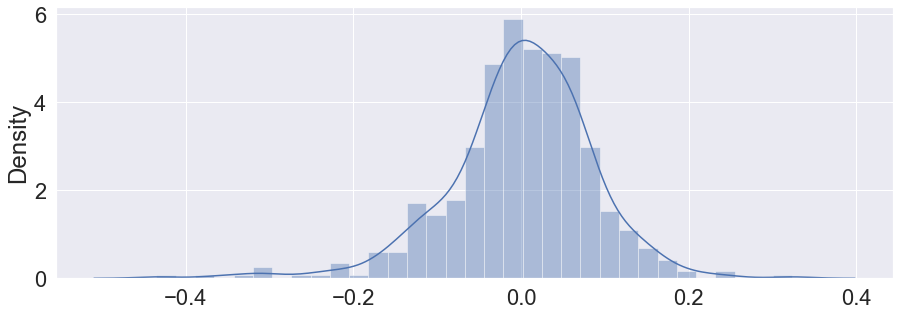

In [258]:
# residual analysis for training dataset features using RFE 

# predicted values for target varibale in training dataset
y_train_pred_01=stat_model_01.predict(X_train_rfe_sm_01)

# residual plot
residuals_01 = y_train - y_train_pred_01

plt.figure(figsize=(15,5))

sns.distplot(residuals_01)
plt.show()

### build stat model after dropping columns with high p-value of vif score.

* column '02_feb' have vre highp-value, check by excluding this column

In [259]:
# new index of columns after dropping '02_feb' column
useful_features_01=useful_features.drop('02_feb')

In [268]:
useful_features_01

Index(['yr_19', 'holiday', 'workingday', 'spring', 'summer', 'winter',
       'light_fall', 'mist', '03_mar', '04_apr', '05_may', '06_jun', '08_aug',
       '09_sep', '10_oct', '6_Sat', 'temp', 'hum', 'windspeed'],
      dtype='object')

In [271]:
# stat model

stat_model_02=stat_model_func(columns=useful_features_01)

stat_model_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     147.3
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          1.29e-188
Time:                        22:14:57   Log-Likelihood:                 524.44
No. Observations:                 510   AIC:                            -1009.
Df Residuals:                     490   BIC:                            -924.2
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2392      0.037      6.434      0.000       0.166       0.312
yr_19          0.2312      0.008     28.931      0.000       0.215       0.247
holiday       -0.0491      0.027     -1.830      0.068      -0.102       0.004
workingday     0.0435      0.011      3.787      0.000       0.021       0.066
spring        -0.0481      0.023     -2.100      0.036      -0.093      -0.003
summer         0.0414      0.024      1.711      0.088      -0.006       0.089
winter         0.1092      0.020      5.474      0.000       0.070       0.148
light_fall    -0.2522      0.026     -9.664      0.000      -0.303      -0.201
mist          -0.0584      0.010     -5.658      0.000      -0.079      -0.038
03_mar         0.0462      0.017      2.757      0.006       0.013       0.079
04_apr         0.0417      0.026      1.634      0.103      -0.008       0.092
05_may         0.0653      0.026      2.510      0.012       0.014       0.116
06_jun         0.0417      0.022      1.863      0.063      -0.002       0.086
08_aug         0.0569      0.018      3.174      0.002       0.022       0.092
09_sep         0.1243      0.017      7.153      0.000       0.090       0.158
10_oct         0.0464      0.017      2.659      0.008       0.012       0.081
6_Sat          0.0531      0.014      3.673      0.000       0.025       0.081
temp           0.4640      0.037     12.633      0.000       0.392       0.536
hum           -0.1596      0.038     -4.234      0.000      -0.234      -0.086
windspeed     -0.1834      0.025     -7.210      0.000      -0.233      -0.133
==============================================================================
Omnibus:                       81.126   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.386
Skew:                          -0.773   Prob(JB):                     1.14e-49
Kurtosis:                       5.866   Cond. No.                         24.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* p-value of columns {holiday, summer, 04_apr, 06_jun} is more than 0.05.
* r2 score is good.

In [274]:
# vif

vif_func(columns=useful_features_01)

,Features,VIF
0,const,90.44
5,summer,7.11
4,spring,6.32
6,winter,4.85
17,temp,4.50
11,05_may,3.42
10,04_apr,3.09
12,06_jun,2.32
18,hum,1.97
3,workingday,1.89


* vif values of {summer, spring} columns is more than 5.

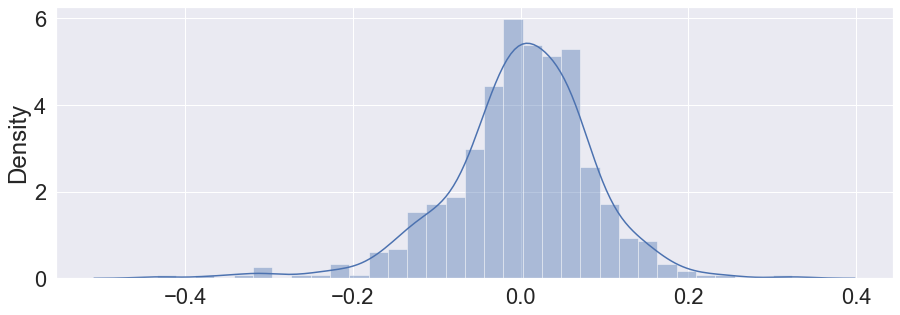

<AxesSubplot:ylabel='Density'>

In [276]:
# plot residuals

plot_residuals_func(useful_features_01)

* column 'summer' have very high p-value as well as high vif, check by excluding this column

In [288]:
# new index of columns after dropping 'summer' column
useful_features_02=useful_features.drop(['02_feb','summer'])

In [289]:
useful_features_02

Index(['yr_19', 'holiday', 'workingday', 'spring', 'winter', 'light_fall',
       'mist', '03_mar', '04_apr', '05_may', '06_jun', '08_aug', '09_sep',
       '10_oct', '6_Sat', 'temp', 'hum', 'windspeed'],
      dtype='object')

In [290]:
# stat model

stat_model_03=stat_model_func(columns=useful_features_02)

stat_model_03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     154.8
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          4.37e-189
Time:                        22:22:51   Log-Likelihood:                 522.92
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     491   BIC:                            -927.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2605      0.035      7.424      0.000       0.192       0.329
yr_19          0.2320      0.008     29.037      0.000       0.216       0.248
holiday       -0.0474      0.027     -1.764      0.078      -0.100       0.005
workingday     0.0438      0.011      3.805      0.000       0.021       0.066
spring        -0.0710      0.019     -3.806      0.000      -0.108      -0.034
winter         0.0932      0.018      5.279      0.000       0.059       0.128
light_fall    -0.2550      0.026     -9.771      0.000      -0.306      -0.204
mist          -0.0588      0.010     -5.687      0.000      -0.079      -0.038
03_mar         0.0599      0.015      4.050      0.000       0.031       0.089
04_apr         0.0696      0.020      3.526      0.000       0.031       0.108
05_may         0.0971      0.018      5.300      0.000       0.061       0.133
06_jun         0.0629      0.019      3.367      0.001       0.026       0.100
08_aug         0.0520      0.018      2.933      0.004       0.017       0.087
09_sep         0.1195      0.017      6.955      0.000       0.086       0.153
10_oct         0.0491      0.017      2.823      0.005       0.015       0.083
6_Sat          0.0539      0.014      3.721      0.000       0.025       0.082
temp           0.4348      0.033     13.345      0.000       0.371       0.499
hum           -0.1512      0.037     -4.037      0.000      -0.225      -0.078
windspeed     -0.1807      0.025     -7.103      0.000      -0.231      -0.131
==============================================================================
Omnibus:                       83.130   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              240.522
Skew:                          -0.779   Prob(JB):                     5.91e-53
Kurtosis:                       5.982   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* p-value of columns {holiday} is more than 0.05.
* r2 score is good.

In [291]:
# vif

vif_func(columns=useful_features_02)

,Features,VIF
0,const,80.27
4,spring,4.17
5,winter,3.78
16,temp,3.52
17,hum,1.94
3,workingday,1.89
9,04_apr,1.83
15,6_Sat,1.79
12,08_aug,1.78
10,05_may,1.69


* vif values of all columns is less than 5.

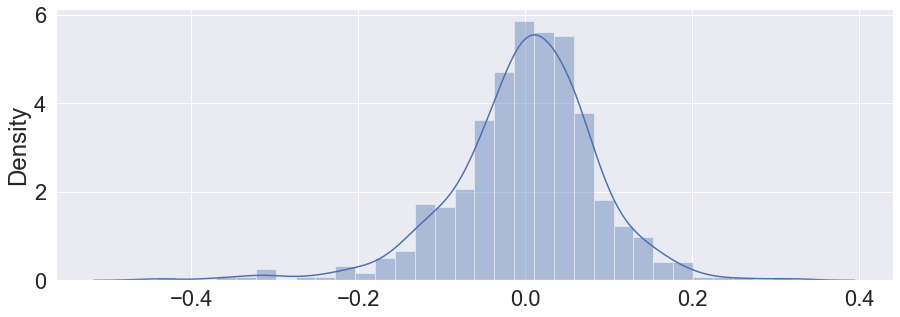

<AxesSubplot:ylabel='Density'>

In [292]:
# plot residuals

plot_residuals_func(useful_features_02)

* column 'holiday' have vre high p-value, check by excluding this column

In [296]:
# new index of columns after dropping '02_feb' column
useful_features_03=useful_features.drop(['02_feb','summer','holiday'])

In [297]:
useful_features_03

Index(['yr_19', 'workingday', 'spring', 'winter', 'light_fall', 'mist',
       '03_mar', '04_apr', '05_may', '06_jun', '08_aug', '09_sep', '10_oct',
       '6_Sat', 'temp', 'hum', 'windspeed'],
      dtype='object')

In [298]:
# stat model

stat_model_03=stat_model_func(columns=useful_features_03)

stat_model_03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     163.0
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          1.58e-189
Time:                        22:24:39   Log-Likelihood:                 521.31
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     492   BIC:                            -930.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2534      0.035      7.254      0.000       0.185       0.322
yr_19          0.2322      0.008     29.003      0.000       0.216       0.248
workingday     0.0507      0.011      4.688      0.000       0.029       0.072
spring        -0.0722      0.019     -3.866      0.000      -0.109      -0.036
winter         0.0920      0.018      5.206      0.000       0.057       0.127
light_fall    -0.2545      0.026     -9.732      0.000      -0.306      -0.203
mist          -0.0586      0.010     -5.659      0.000      -0.079      -0.038
03_mar         0.0611      0.015      4.131      0.000       0.032       0.090
04_apr         0.0695      0.020      3.513      0.000       0.031       0.108
05_may         0.0978      0.018      5.329      0.000       0.062       0.134
06_jun         0.0639      0.019      3.417      0.001       0.027       0.101
08_aug         0.0526      0.018      2.958      0.003       0.018       0.088
09_sep         0.1181      0.017      6.869      0.000       0.084       0.152
10_oct         0.0504      0.017      2.894      0.004       0.016       0.085
6_Sat          0.0609      0.014      4.373      0.000       0.034       0.088
temp           0.4342      0.033     13.300      0.000       0.370       0.498
hum           -0.1501      0.038     -4.000      0.000      -0.224      -0.076
windspeed     -0.1813      0.025     -7.113      0.000      -0.231      -0.131
==============================================================================
Omnibus:                       89.025   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.096
Skew:                          -0.820   Prob(JB):                     6.08e-59
Kurtosis:                       6.151   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* p-value of columns is almost 0, thus all are significant.

In [299]:
# vif

vif_func(columns=useful_features_03)

,Features,VIF
0,const,79.20
3,spring,4.17
4,winter,3.78
15,temp,3.52
16,hum,1.94
8,04_apr,1.83
11,08_aug,1.78
9,05_may,1.69
2,workingday,1.66
14,6_Sat,1.65


* vif values of all columns is less than 5.

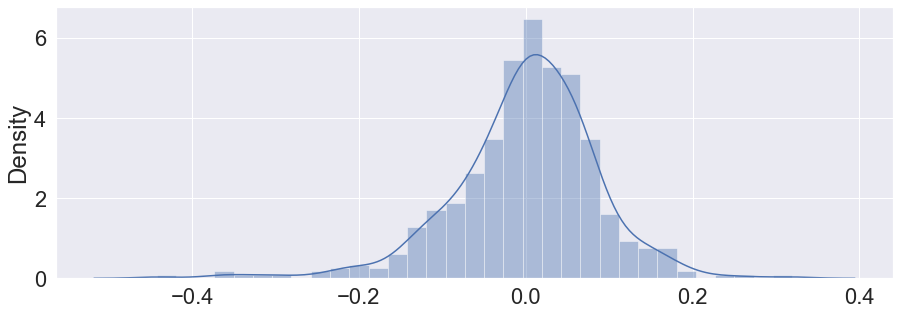

<AxesSubplot:ylabel='Density'>

In [300]:
# plot residuals

plot_residuals_func(useful_features_03)

### model after coarse& fine tunning

In [304]:
# columns 
useful_features_new=useful_features_03
useful_features_new

Index(['yr_19', 'workingday', 'spring', 'winter', 'light_fall', 'mist',
       '03_mar', '04_apr', '05_may', '06_jun', '08_aug', '09_sep', '10_oct',
       '6_Sat', 'temp', 'hum', 'windspeed'],
      dtype='object')

In [305]:
# create stats model

# columns array
useful_features_new

# create dataframe
X_train_rfe_new=X_train_rfe[useful_features_new]

# add constant
X_train_rfe_sm_new=sm.add_constant(X_train_rfe_new)

# create model and fit
stat_model_new=sm.OLS(y_train,X_train_rfe_sm_new).fit()

# summary
stat_model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     163.0
Date:                Thu, 06 Oct 2022   Prob (F-statistic):          1.58e-189
Time:                        08:10:24   Log-Likelihood:                 521.31
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     492   BIC:                            -930.4
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2534      0.035      7.254      0.000       0.185       0.322
yr_19          0.2322      0.008     29.003      0.000       0.216       0.248
workingday     0.0507      0.011      4.688      0.000       0.029       0.072
spring        -0.0722      0.019     -3.866      0.000      -0.109      -0.036
winter         0.0920      0.018      5.206      0.000       0.057       0.127
light_fall    -0.2545      0.026     -9.732      0.000      -0.306      -0.203
mist          -0.0586      0.010     -5.659      0.000      -0.079      -0.038
03_mar         0.0611      0.015      4.131      0.000       0.032       0.090
04_apr         0.0695      0.020      3.513      0.000       0.031       0.108
05_may         0.0978      0.018      5.329      0.000       0.062       0.134
06_jun         0.0639      0.019      3.417      0.001       0.027       0.101
08_aug         0.0526      0.018      2.958      0.003       0.018       0.088
09_sep         0.1181      0.017      6.869      0.000       0.084       0.152
10_oct         0.0504      0.017      2.894      0.004       0.016       0.085
6_Sat          0.0609      0.014      4.373      0.000       0.034       0.088
temp           0.4342      0.033     13.300      0.000       0.370       0.498
hum           -0.1501      0.038     -4.000      0.000      -0.224      -0.076
windspeed     -0.1813      0.025     -7.113      0.000      -0.231      -0.131
==============================================================================
Omnibus:                       89.025   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.096
Skew:                          -0.820   Prob(JB):                     6.08e-59
Kurtosis:                       6.151   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [307]:
# variance inflation factor of model features

# create empty dataframe
vif_new=pd.DataFrame()

# create feature columns with columns names in stat-model dataframe(including constant)
vif_new['Features']=X_train_rfe_sm_new.columns
# create and set vif columns values to vif values for each column
vif_new['VIF']=[round(variance_inflation_factor(X_train_rfe_sm_new.values,i),2) for i in range(X_train_rfe_sm_new.shape[1])]

# sort vif dataframe by vif values
vif_new = vif_new.sort_values(by='VIF',ascending=True)

vif_new

,Features,VIF
1,yr_19,1.04
17,windspeed,1.21
7,03_mar,1.26
5,light_fall,1.27
12,09_sep,1.42
13,10_oct,1.52
6,mist,1.57
10,06_jun,1.61
14,6_Sat,1.65
2,workingday,1.66


### features contributing significantly towards explaining the demand of the shared bikes

In [318]:
stat_model_new.params.sort_values(ascending=False)

temp          0.434234
const         0.253394
yr_19         0.232232
09_sep        0.118129
05_may        0.097777
winter        0.092049
04_apr        0.069454
06_jun        0.063946
03_mar        0.061120
6_Sat         0.060941
08_aug        0.052589
workingday    0.050733
10_oct        0.050407
mist         -0.058605
spring       -0.072203
hum          -0.150095
windspeed    -0.181315
light_fall   -0.254504
dtype: float64

* having coefficients absolute value
    * temp: temperature : 0.434234
    * light_fall : light fall weather situation : -0.254504
    * yr_19 : year 2019 : 0.232232

In [ ]:
# plots of most significant features

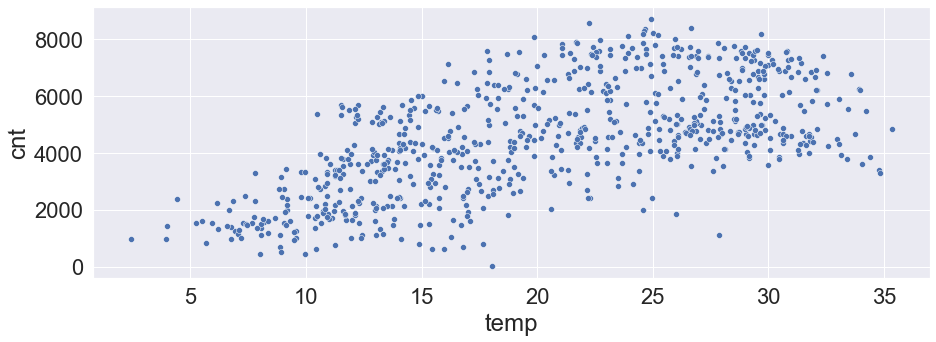

In [323]:
# temp: temperature

plt.figure(figsize=(15,5))
sns.scatterplot(data=data,x='temp',y='cnt')
plt.show()

* bike demand increases with temperature.

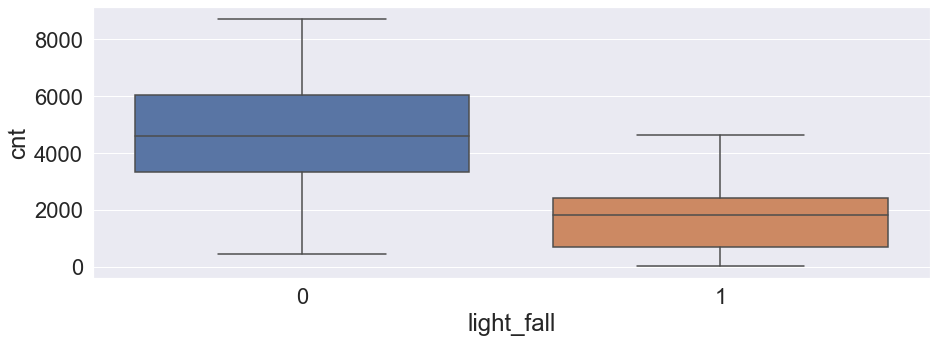

In [325]:
# light_fall : light fall weather situation

plt.figure(figsize=(15,5))
sns.boxplot(data=data,x='light_fall',y='cnt')
plt.show()

* more bike dmeand when there is no light fall.

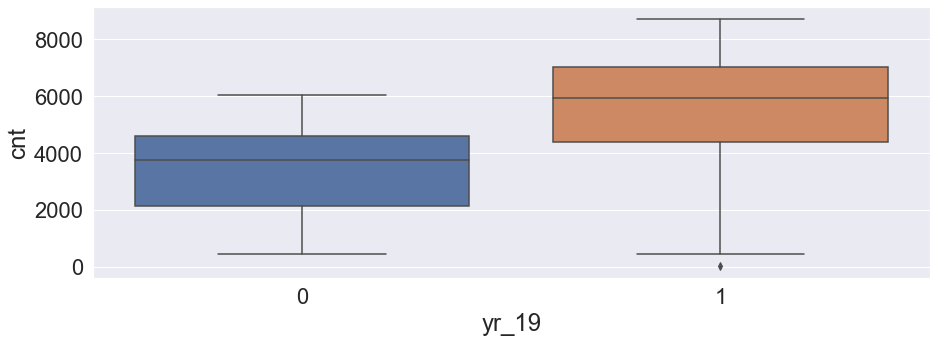

In [327]:
# yr_19 : year 2019 

plt.figure(figsize=(15,5))
sns.boxplot(data=data,x='yr_19',y='cnt')
plt.show()

* more demand for year 2019

### testing model

In [328]:
# scaling continuous varibales {continuous_parameters} of validation dataset, and transforming them using training dataset 

data_val[continuous_parameters]=scaler.transform(data_val[continuous_parameters])

In [329]:
# scaling continuous varibales {continuous_parameters} of test dataset, and transforming them using training dataset 

data_test[continuous_parameters]=scaler.transform(data_test[continuous_parameters])

In [332]:
# validation dataset

data_val.head()

,yr_19,holiday,workingday,spring,summer,winter,light_fall,mist,02_feb,03_mar,04_apr,05_may,06_jun,07_jul,08_aug,09_sep,10_oct,11_nov,12_dec,1_Mon,2_Tue,3_Wed,4_Thur,5_Fri,6_Sat,temp,temp_dif_f,hum,windspeed,cnt
729,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0.195259,0.800888,0.595105,0.241943,0.311436
173,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.833859,0.901888,0.724774,0.422436,0.548550
213,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0.902392,0.837650,0.506226,0.351591,0.554878
723,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0.289300,0.819218,0.757183,0.271782,0.114013
432,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.438239,0.828501,0.419493,0.800793,0.523125


In [333]:
# testing dataset

data_test[continuous_parameters].head()

,temp,temp_dif_f,hum,windspeed,cnt
685,-0.063611,0.740511,0.005792,-0.081466,-0.002457
157,-0.049126,0.741805,0.006349,-0.080909,-0.002467
69,-0.063932,0.739337,0.006898,-0.077794,-0.002505
363,-0.064116,0.740784,0.006761,-0.084597,-0.002492
436,-0.054522,0.742116,0.006557,-0.077519,-0.002454


In [87]:
# using {cnt} as -- target variables
# using all other variables except {casual,registered} as -- feature variables --using selected useful features in rfe

y_test=data_test['cnt']
X_test=data_test[final_columns]

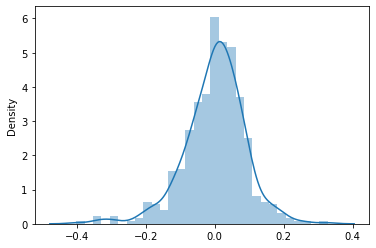

In [88]:
# predicted variable  test values

# add constant to X_test
X_test_sm=sm.add_constant(X_test)

# predicted values
y_test_pred=stat_model.predict(X_test_sm)

# residual
residual = y_train - y_train_pred

# plot
sns.distplot(residual)
plt.show()

# model evaluation

## r2 score

In [89]:
# training datatset
r2_score(y_true=y_train,y_pred=y_train_pred)

0.8427518254725355

In [90]:
# testing datatset
r2_score(y_true=y_test,y_pred=y_test_pred)

0.820137782558575

* r2 score of train and test dataset are similar.

## mean square error

In [91]:
mean_squared_error(y_test,y_test_pred)

0.008599982337576674

## root mean square error

In [92]:
np.sqrt(mean_squared_error(y_test, y_test_pred))

0.0927360897255037

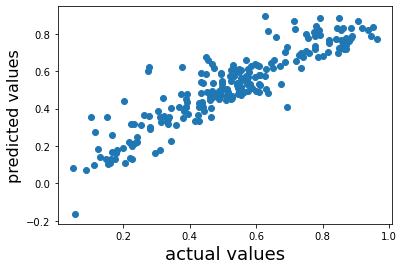

In [98]:
# comparison of actual and perdicted values

fig = plt.figure()

plt.scatter(y_test,y_test_pred)

plt.xlabel('actual values', fontsize=18)                        
plt.ylabel('predicted values', fontsize=16)                     

plt.show()

In [95]:
# summary of model

print(stat_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     176.5
Date:                Tue, 27 Sep 2022   Prob (F-statistic):          2.50e-187
Time:                        21:13:44   Log-Likelihood:                 510.63
No. Observations:                 510   AIC:                            -989.3
Df Residuals:                     494   BIC:                            -921.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2889      0.034      8.599      0.0